# Dataset, model 설정
resnet34를 사용, transfer learning으로 한다. 

In [1]:
import torch
import torch.nn as nn

import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [3]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder('./dataset/train', simple_transform)
test = ImageFolder('./dataset/test', simple_transform)

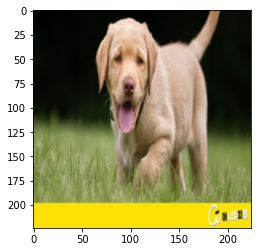

In [4]:
imshow(train[50][0])

In [5]:
train_data_gen = torch.utils.data.DataLoader(train, shuffle=True, batch_size=40, num_workers=3)
test_data_gen = torch.utils.data.DataLoader(test, batch_size=40, num_workers=3)

dataset_sizes = {'train' : len(train_data_gen.dataset), 'test' : len(test_data_gen.dataset)}

dataloaders = {'train' : train_data_gen, 'test' : test_data_gen}

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,120)

# fitting
dataset이 적어서 과적합 이슈로 epoch는 6~7정도가 적당한 것 같음\
악어dataset에서 하나 삭제

In [7]:
from torch import optim
from torch.optim import lr_scheduler

parameter setting

In [8]:
if torch.cuda.is_available():
    model_ft = model_ft.cuda()
    
learning_rate = 0.001
num_epochs = 7

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
def train_model(model, num_epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train','test']:
            if phase == 'train':
                model.train()
            if phase == 'test':
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data
                
                if torch.cuda.is_available():
                    inputs, labels = inputs.cuda(), labels.cuda()
                    
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
    print('Best val Acc: {:4f}'.format(best_acc))
    
    return model

In [10]:
model_ft = train_model(model_ft, num_epochs=num_epochs)

Epoch 0/6
----------
train Loss: 0.1086 Acc: 0.1465
test Loss: 0.0877 Acc: 0.3612
Epoch 1/6
----------
train Loss: 0.0715 Acc: 0.5509
test Loss: 0.0608 Acc: 0.5748
Epoch 2/6
----------
train Loss: 0.0492 Acc: 0.7203
test Loss: 0.0474 Acc: 0.6466
Epoch 3/6
----------
train Loss: 0.0365 Acc: 0.7982
test Loss: 0.0404 Acc: 0.6845
Epoch 4/6
----------
train Loss: 0.0285 Acc: 0.8463
test Loss: 0.0357 Acc: 0.7076
Epoch 5/6
----------
train Loss: 0.0229 Acc: 0.8799
test Loss: 0.0327 Acc: 0.7179
Epoch 6/6
----------
train Loss: 0.0186 Acc: 0.9106
test Loss: 0.0305 Acc: 0.7332
Best val Acc: 0.733196


## save torch model 

In [11]:
torch.save(model_ft.state_dict(),'./model')

export to onnx model

In [12]:
dummy_input = torch.zeros(1,3,224,224).cuda()
torch.onnx.export(model_ft, dummy_input, 'model.onnx',verbose=True)

graph(%input.1 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %fc.weight : Float(120, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %fc.bias : Float(120, strides=[1], requires_grad=1, device=cuda:0),
      %193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cuda:0),
      %194 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %197 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %200 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %203 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %205 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %20

In [1]:
import onnx
from onnx import shape_inference
path = "./model.onnx"

In [ ]:
onnx.save(onnx.shape_inference.infer_shapes(onnx.load(path)),path)

In [2]:
model = onnx.load(path)

model.graph.input

[name: "input.1"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 224
      }
      dim {
        dim_value: 224
      }
    }
  }
}
]